In [1]:
"""
June 26, 2020

Looking at starting position of walkers.
"""

import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

Ms = np.linspace(7, 12, 60)

# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [7]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [8]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [ ]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

for z in redshifts:
# z = redshifts[0]
    print(z)

    # smf = pop.StellarMassFunction(z, Ms)
    # pl.semilogy(Ms, smf, label='guess')
    data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

    pl.title("z = %.2f" %z)
    pl.legend()
    pl.show()

In [105]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [106]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [107]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [108]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.08, 0.01]
# fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 2 (parameter pq_func_par0[1])
# Moved from -0.022116207155998106 to 0.0028270005621651405
# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.16856442813730743 to 0.12187264402512323
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.03339842593830754 to 0.08729131490176868
# Fixing position of walker 6 (parameter pq_func_par0[1])
# Moved from -0.06752159611716693 to 0.0687695803869682
# Fixing position of walker 7 (parameter pq_func_par0[1])
# Moved from -0.19832609780521324 to 0.020663808117549275
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.11660235332074018 to 0.025389351002186412
# Fixing position of walker 17 (parameter pq_func_par0[1])
# Moved from -0.07328882100599417 to 0.10260563536211864
# Fixing position of walker 22 (parameter pq_func_par0[1])
# Moved from -0.08635211468766862 to 0.025389351002186412
# Fixing position of walker 23 (parameter pq_func_par0[1])
# Moved from -

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best

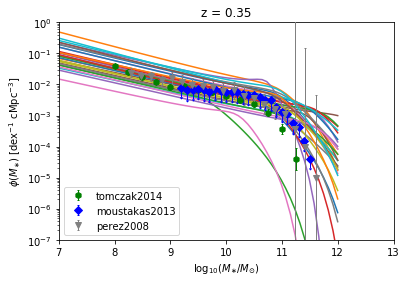

In [110]:
z = 0.35
# 2.5, 3.5

for w in fitter.guesses[:]:
#     print(w)
    
    pars_ch = {}
    for i in range(len(w)):
        pars_ch[free_pars[i]] = w[i]
        
    base_pars.update(pars_ch)
    pop = ares.populations.GalaxyPopulation(**base_pars)

    smf = pop.StellarMassFunction(z, Ms)
    pl.semilogy(Ms, smf)#, label='guess')

data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.title("z = %.2f" %z)
pl.legend()
pl.show()
    

In [ ]:
fitter.run('MCMC_files/test_smfcal_5', burn=5, steps=40, save_freq=4, clobber=True)

In [4]:
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2_07_09')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
anl = ares.analysis.ModelSet('..\Cedar\savedFits/smf_09_07_13')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ..\Cedar\savedFits/                                                                    ####
#### prefix      : smf_09_07_13                                                                           ####
#### N-d         : 8                                                                                      ####


# Loading ..\Cedar\savedFits/smf_09_07_13.dd*.chain.pkl...
# Loaded ..\Cedar\savedFits/smf_09_07_13.dd*.chain.pkl in 0.073 s.
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0000.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0001.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0002.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0003.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0004.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0005.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0006.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0007.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0008.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0009.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0010.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\savedFits\smf_09_07_13.dd0011.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar\save

C:\Users\Emma\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


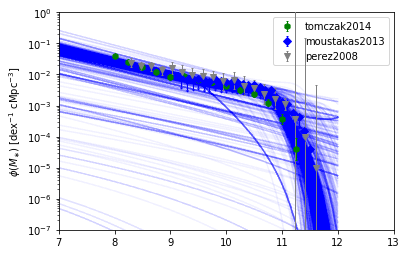

In [5]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [6]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.111762e+00
pq_func_par2[0]: 1.358215e-01
pq_func_par0[1]: 8.996644e-02
pq_func_par2[1]: -7.449401e-01
pq_func_par0[2]: 7.166162e-01
pq_func_par2[2]: -1.813168e-01
pq_func_par0[3]: 1.187771e+01
pq_func_par2[3]: 1.340012e-01


0 of 4800 chain elements ignored because of chain links with inf's/nan's.


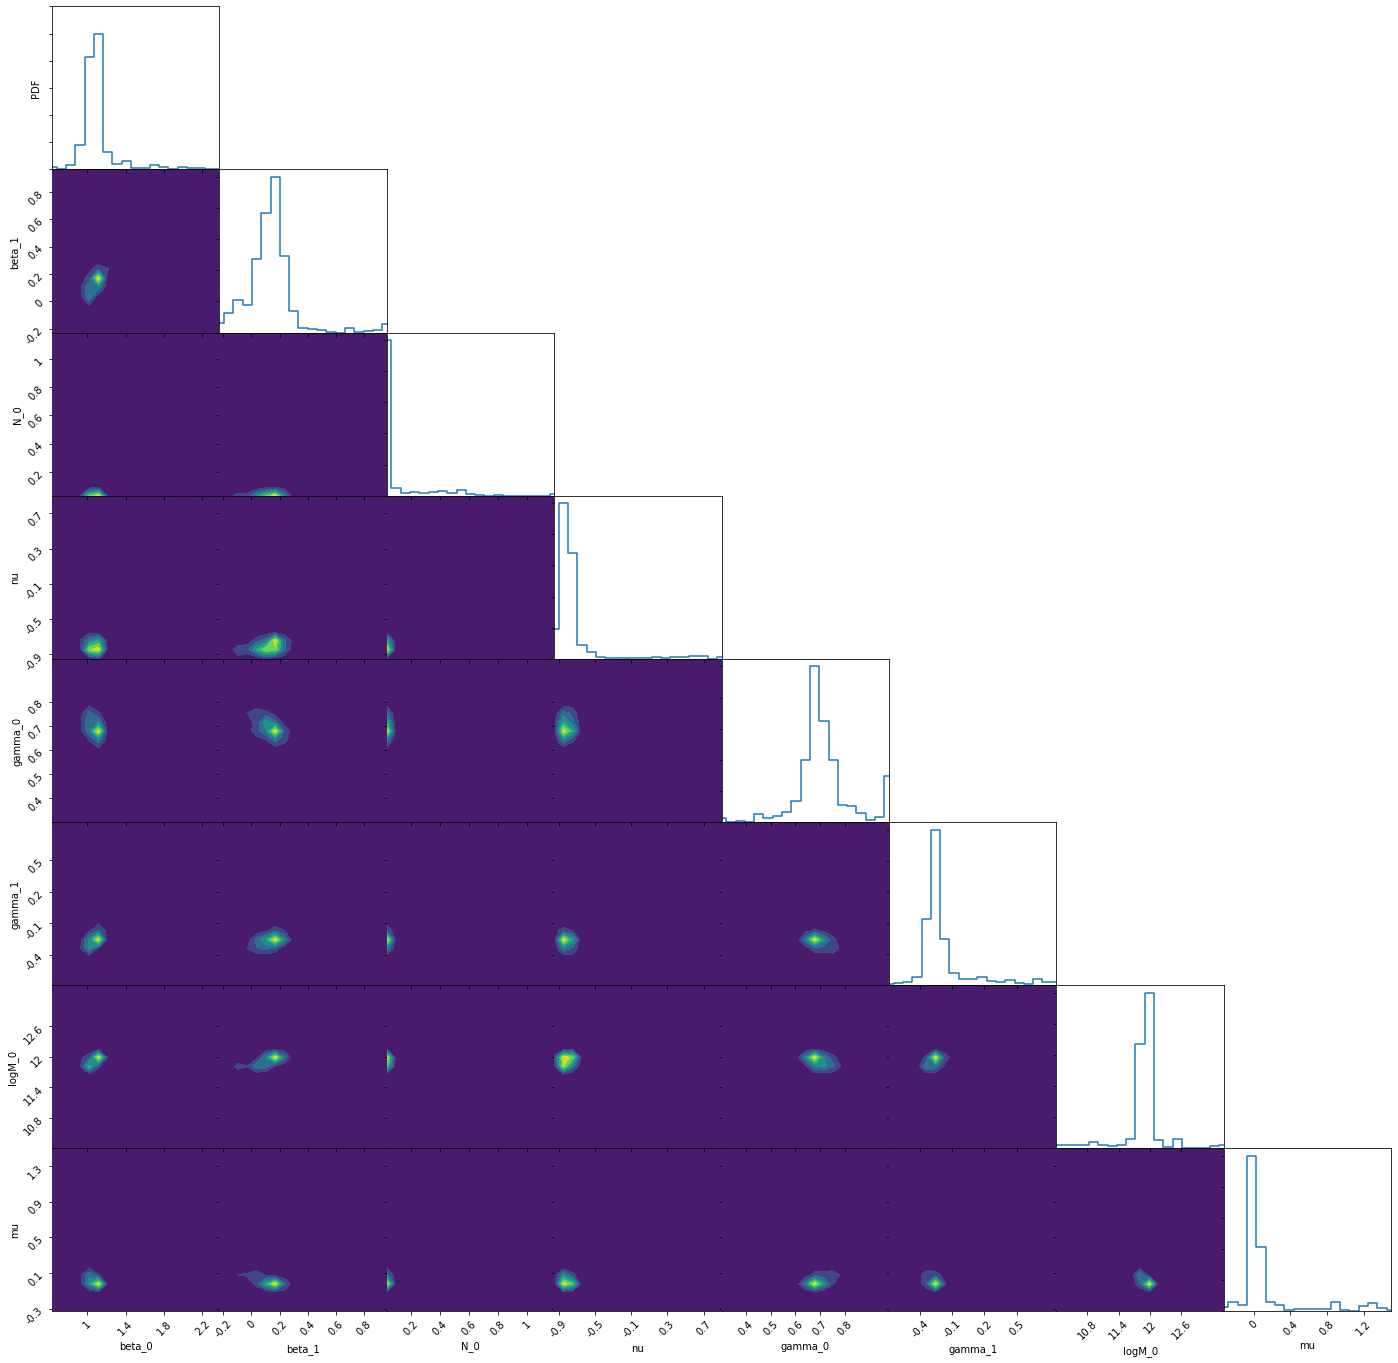

In [7]:

trig = anl.TrianglePlot(pars=params)

In [ ]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [7]:
anl.max_likelihood_parameters()

4101
[[4101]
 [4102]
 [4103]]


{'pq_func_par0[0]': 1.0188433493717852,
 'pq_func_par2[0]': -0.10503294384729508,
 'pq_func_par0[1]': 0.02399510308556068,
 'pq_func_par2[1]': -0.8208833911295287,
 'pq_func_par0[2]': 0.767508351681384,
 'pq_func_par2[2]': -0.3057925784314496,
 'pq_func_par0[3]': 11.817246978978826,
 'pq_func_par2[3]': 0.04921542557552573}

In [19]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.111762e+00
pq_func_par2[0]: 1.358215e-01
pq_func_par0[1]: 8.996644e-02
pq_func_par2[1]: -7.449401e-01
pq_func_par0[2]: 7.166162e-01
pq_func_par2[2]: -1.813168e-01
pq_func_par0[3]: 1.187771e+01
pq_func_par2[3]: 1.340012e-01


In [20]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [30]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.0188433493717852, array([0.13916481, 0.02547794]))
(-0.10503294384729508, array([ 0.32837801, -0.11129812]))
(0.02399510308556068, array([0.08750096, 0.00410349]))
(-0.8208833911295287, array([0.08305552, 0.03645086]))
(0.767508351681384, array([0.02367922, 0.12534986]))
(-0.3057925784314496, array([0.21186335, 0.00853489]))
(11.817246978978826, array([0.21569128, 0.02638174]))
(0.04921542557552573, array([0.09900946, 0.05607204]))


In [22]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 1.0188433493717852, 'pq_func_par2[0]': -0.10503294384729508, 'pq_func_par0[1]': 0.02399510308556068, 'pq_func_par2[1]': -0.8208833911295287, 'pq_func_par0[2]': 0.767508351681384, 'pq_func_par2[2]': -0.3057925784314496, 'pq_func_par0[3]': 11.817246978978826, 'pq_func_par2[3]': 0.04921542557552573}


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
[8.60855752e-02 8.06122131e-02 7.54897636e-02 7.06954750e-02
 6.62081260e-02 6.20079361e-02 5.80764101e-02 5.43961854e-02
 5.09510725e-02 4.77259795e-02 4.47067766e-02 4.18802057e-02
 3.92339114e-02 3.67563738e-02 3.44367957e-02 3.22650479e-02
 3.02316953e-02 2.83279401e-02 2.65455292e-02 2.48767246e-02
 2.33143161e-02 2.18515815e-02 2.04822126e-02 1.92002978e-02
 1.80003265e-02 1.68771616e-02 1.58259847e-02 1.48422807e-02
 1.39218401e-02 1.30607407e-02 1.22553096e-02 1.15021033e-02
 1.07979148e-02 1.01397587e-02 9.52484759e-03 8.95057302e-03
 8.41450996e-03 7.91440398e-03 7.44816604e-03 7.01385593e-03
 6.60967640e-03 6.23397175e-03 5.88522571e-03 5.56205322e-03
 5.26319931e-03 4.98753505e-03 4.73405360e-03 4.50186524e-03
 4.29018523e-03 4.09830768e-03 3.92555199e-03 3.77114906e-03
 3.63400728e-03 3.51224016e-03 3.40221180e-03 3.29660526e-03
 3.18091813e-03 3.02811170e-03 2.79523324e-03 2.4369

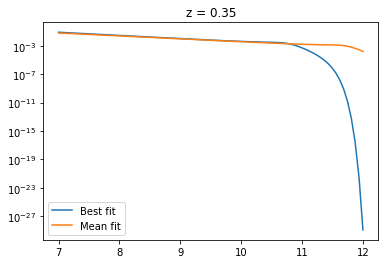

In [12]:
z = 0.35

Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
# obslf.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

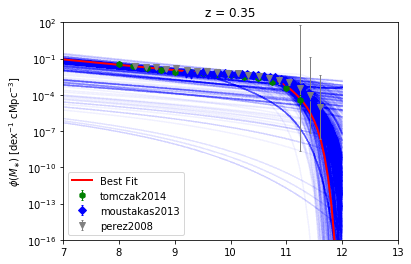

In [13]:
z = .35

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# print(ls_best)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms_short, ls_best, label='Best Fit', color="red", linewidth=2)

pl.title("z = %.2f" %z)
pl.legend()
pl.ylim(1e-16, 1e2)
pl.show()


In [20]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.ticker import LinearLocator, FormatStrFormatter

(50, 80)


C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


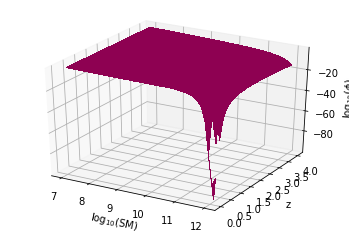

In [21]:
fig = pl.figure()
ax = fig.gca(projection='3d')

zArr = np.linspace(.01, 4, 50)

M, Z = np.meshgrid(Ms_short, zArr)

ls_best_grid = np.array([pop_best.StellarMassFunction(z, Ms_short) for z in zArr])

print(ls_best_grid.shape)

surf = ax.plot_surface(M, Z, np.log10(ls_best_grid), cmap=pl.cm.PiYG, linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.zaxis.set_scale('log')

ax.set_xlabel('log$_{10}$(SM)')
ax.set_ylabel('z')
ax.set_zlabel('log$_{10}(\phi)$');

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

pl.show()

981.7949315800038
[35.908841138069704 35.908841138069704 35.908841138069704
 35.908841138069704 976.0687053526144 976.0687053526144 976.0687053526144
 975.6839635688073 975.6839635688073 981.5977142616523 981.7949315800038
 981.7949315800038 981.7949315800038 980.2132614681523 972.1797681052363
 972.4536347244289 972.4466682505775 972.4466682505775 972.9120296576714
 950.9728448833869]


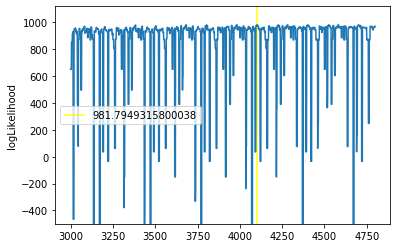

In [12]:
#loglikelihood
ticks = np.linspace(0, len(anl.logL)-1, len(anl.logL))

xstart = 3000

maxL = anl.logL[4101]

print(anl.logL[4101])
print(anl.logL[4101-10:4101+10])

pl.axvline(x=4101, color="yellow", label=str(maxL))

pl.plot(ticks[xstart:], anl.logL[xstart:])
# pl.plot(ticks, anl.logL)
pl.ylabel("logLikelihood")

pl.ylim(-500,)
pl.legend()
pl.show()